# Name: Sai Sriharsha Griddaluru
## Email: sgridda@clemson.edu
## CUID: C15358926


# HW 1: TASK 2: When Gradient Norm is Zero

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
input_data = 20 * torch.rand((1000, 1)) - 10
ground_truth = torch.cos(input_data)

In [5]:
def count_parameters(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

In [3]:
class CosineNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 9)
        self.layer2 = nn.Linear(9, 6)
        self.layer3 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [4]:
def ratio_positive_weights(weights):
    positive_count = sum(w > 0 for w in weights)
    return positive_count / len(weights)

def compute_grad_norm(model):
    grad_norms = [param.weight.grad.norm(2).item() for param in model.modules() if isinstance(param, nn.Linear)]
    return np.mean(grad_norms)

In [6]:
min_ratios = []
losses = []
num_train_runs = 100

for _ in range(num_train_runs):
    epochs = 100
    total_loss = 0
    model = CosineNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(input_data)
        loss = criterion(outputs, ground_truth)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    losses.append(total_loss / len(input_data))
    
    num_params = count_parameters(model)
    hessian = torch.zeros((num_params, num_params))
    
    predictions = model(input_data)
    loss = ((predictions - input_data)**2).mean()
    
    jacobian = torch.autograd.grad(loss, list(model.parameters()), create_graph=True)
    jacobian = torch.cat([param.flatten() for param in jacobian])
    
    for i in range(num_params):
        grad = torch.autograd.grad(jacobian[i], list(model.parameters()), retain_graph=True)
        hessian[i] = torch.cat([g.flatten() for g in grad])
    
    eigenvalues, _ = np.linalg.eig(hessian.detach().numpy())
    min_ratios.append(ratio_positive_weights(eigenvalues))

In [7]:
num_params = count_parameters(model)

hessian = torch.zeros((num_params, num_params))

predictions = model(input_data)
loss = ((predictions - input_data)**2).mean()

jacobian = torch.autograd.grad(loss, list(model.parameters()), create_graph=True)
jacobian = torch.cat([param.flatten() for param in jacobian])

In [8]:
for i in range(num_params):
    grad = torch.autograd.grad(jacobian[i], list(model.parameters()), retain_graph=True)
    hessian[i] = torch.cat([g.flatten() for g in grad])

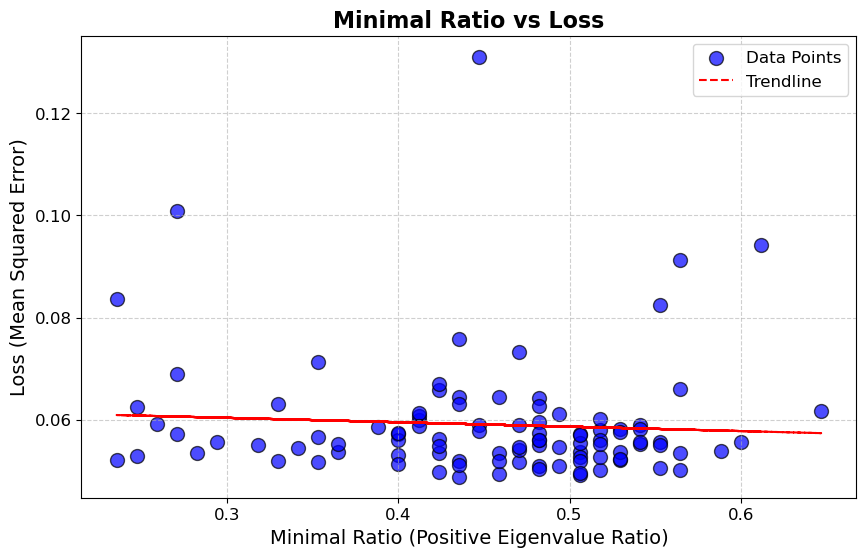

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(min_ratios, losses, color='blue', edgecolor='black', s=100, alpha=0.7, label='Data Points')

# Adding trendline (optional)
z = np.polyfit(min_ratios, losses, 1)
p = np.poly1d(z)
plt.plot(min_ratios, p(min_ratios), "r--", label='Trendline')

# Plot titles and labels
plt.title('Minimal Ratio vs Loss', fontsize=16, fontweight='bold')
plt.xlabel('Minimal Ratio (Positive Eigenvalue Ratio)', fontsize=14)
plt.ylabel('Loss (Mean Squared Error)', fontsize=14)

# Adding grid and customizing ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a legend
plt.legend(fontsize=12)

# Show the plot
plt.show()
